<a href="https://colab.research.google.com/github/Ninaad1007/Weight-Detection-using-Pills-Images/blob/main/PillWeight_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''!apt-get install unzip'''
'''import zipfile

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/pill_main.zip'

# Path to the destination folder where you want to extract the files
extract_path = '/content/drive/MyDrive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)'''

In [42]:
import pandas as pd
import os

path = '/content/drive/MyDrive/pill'
data = []
for filename in os.listdir(path):
    if filename.endswith('.JPG'):
        weight = filename.split('-')[0]
        data.append(weight)

df = pd.DataFrame(data, columns=['Weight'])
print(df)

   Weight
0   1.738
1   1.738
2   1.738
3   1.738
4   1.738
5   1.738
6   1.772
7   1.772
8   1.772
9   1.772
10  1.778
11  1.789
12  1.789
13  1.792
14  1.792
15  1.792
16  1.792
17  1.792
18  1.792
19  1.792
20  1.792
21  1.792
22  1.792
23  1.797
24  1.797
25  1.797
26  1.797
27  1.797
28  1.797
29  1.797
30  1.797
31  1.797
32  1.797
33  1.797
34  1.797
35  1.797
36  1.798
37    1.8
38    1.8
39    1.8
40    1.8
41    1.8
42    1.8
43    1.8
44    1.8


In [43]:
#INVERTED ONE #RUNNING ONE
from tqdm import tqdm
import cv2
import os
import numpy as np

# Define the path to your image directory
path = 'drive/MyDrive/Pills dataset/pills detection project'

# Create empty lists to store your original and filtered images
org = []
images = []
segmented_images = []

# Loop through all the files in your image directory
for filename in tqdm(os.listdir(path)):
    # Load each image using OpenCV
    img = cv2.imread(os.path.join(path,filename))

    # Invert the colors of the image
    inverted_img = cv2.bitwise_not(img)

    # Convert the image to grayscale
    gray = cv2.cvtColor(inverted_img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur with a 5x5 kernel
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Define a sharpening kernel
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

    # Apply the sharpening kernel
    sharpened = cv2.filter2D(blur, -1, kernel)

    # Perform watershed segmentation on the sharpened image
    thresh = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(inverted_img,markers)
    inverted_img[markers == -1] = [255,0,0]
    mask = np.zeros(inverted_img.shape[:2], np.uint8)
    mask[markers != 1] = 255
    segmented_inverted = cv2.bitwise_and(sharpened, sharpened, mask=mask)

    # Invert the colors of the segmented image back
    segmented = cv2.bitwise_not(segmented_inverted)

    # Add the original, sharpened, and segmented images to their respective lists
    org.append(img)
    images.append(sharpened)
    segmented_images.append(segmented)

100%|██████████| 44/44 [00:02<00:00, 21.76it/s]


In [44]:
import pickle

# Define the filename for the pickle file
filename = 'segmented_images.pkl'

# Store the list of segmented images in the pickle file
with open(filename, 'wb') as file:
    pickle.dump(segmented_images, file)

# Load the pickled list of segmented images
with open(filename, 'rb') as file:
    segmented_images = pickle.load(file)

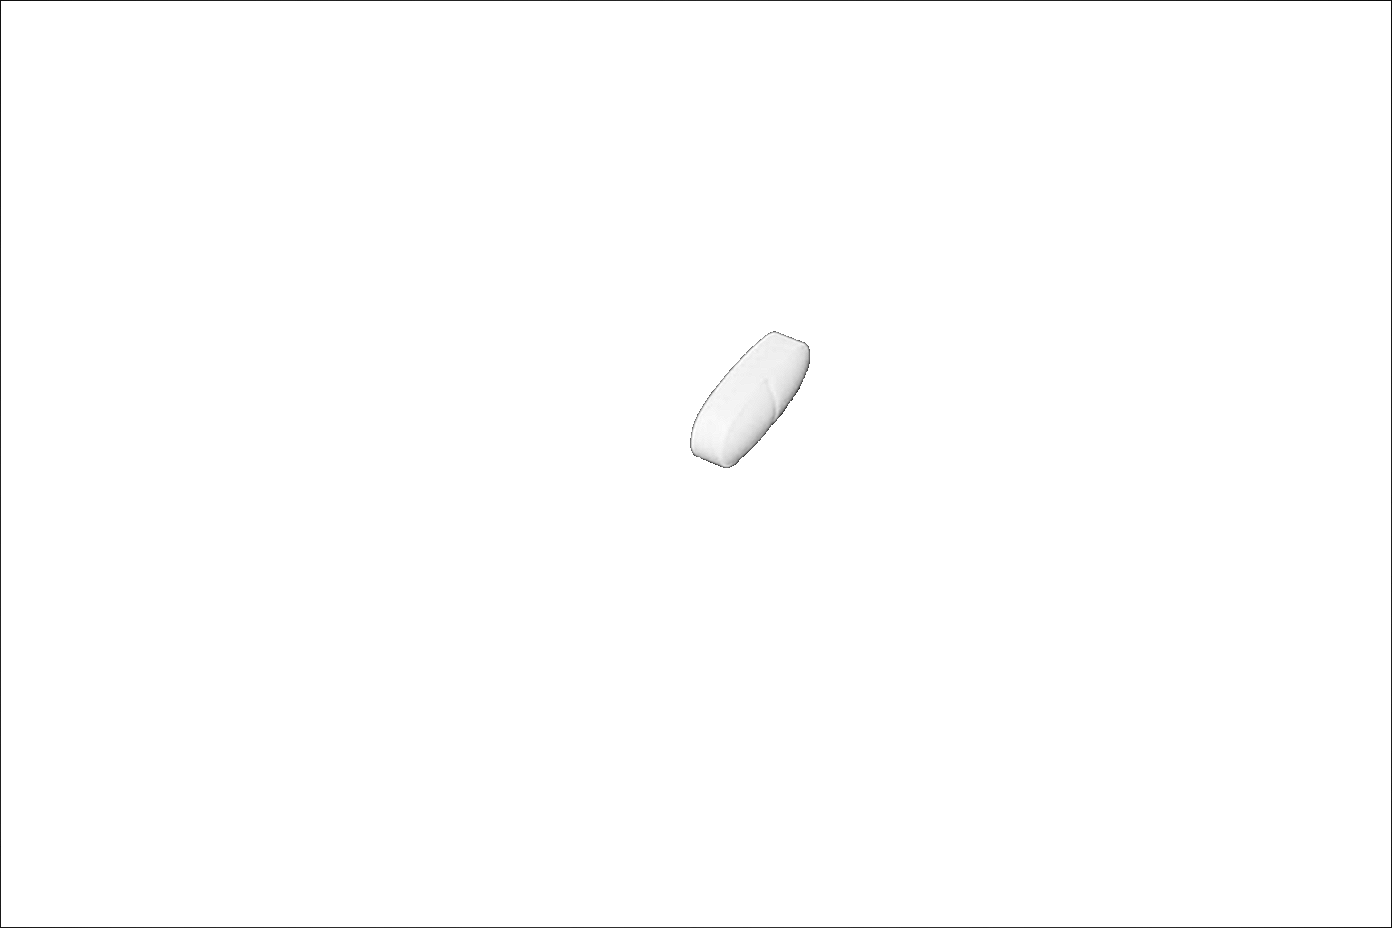

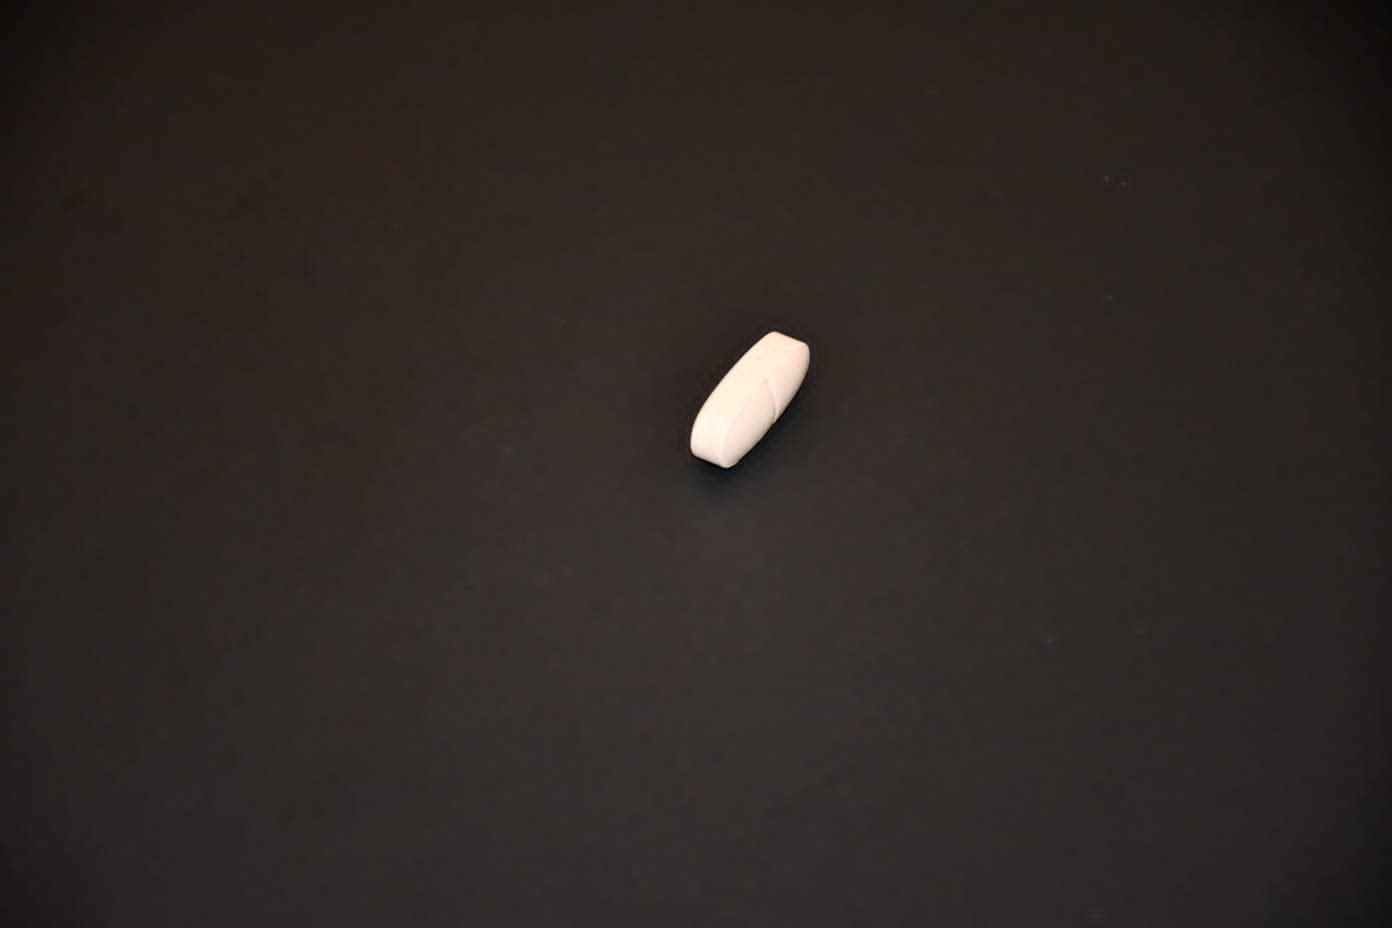

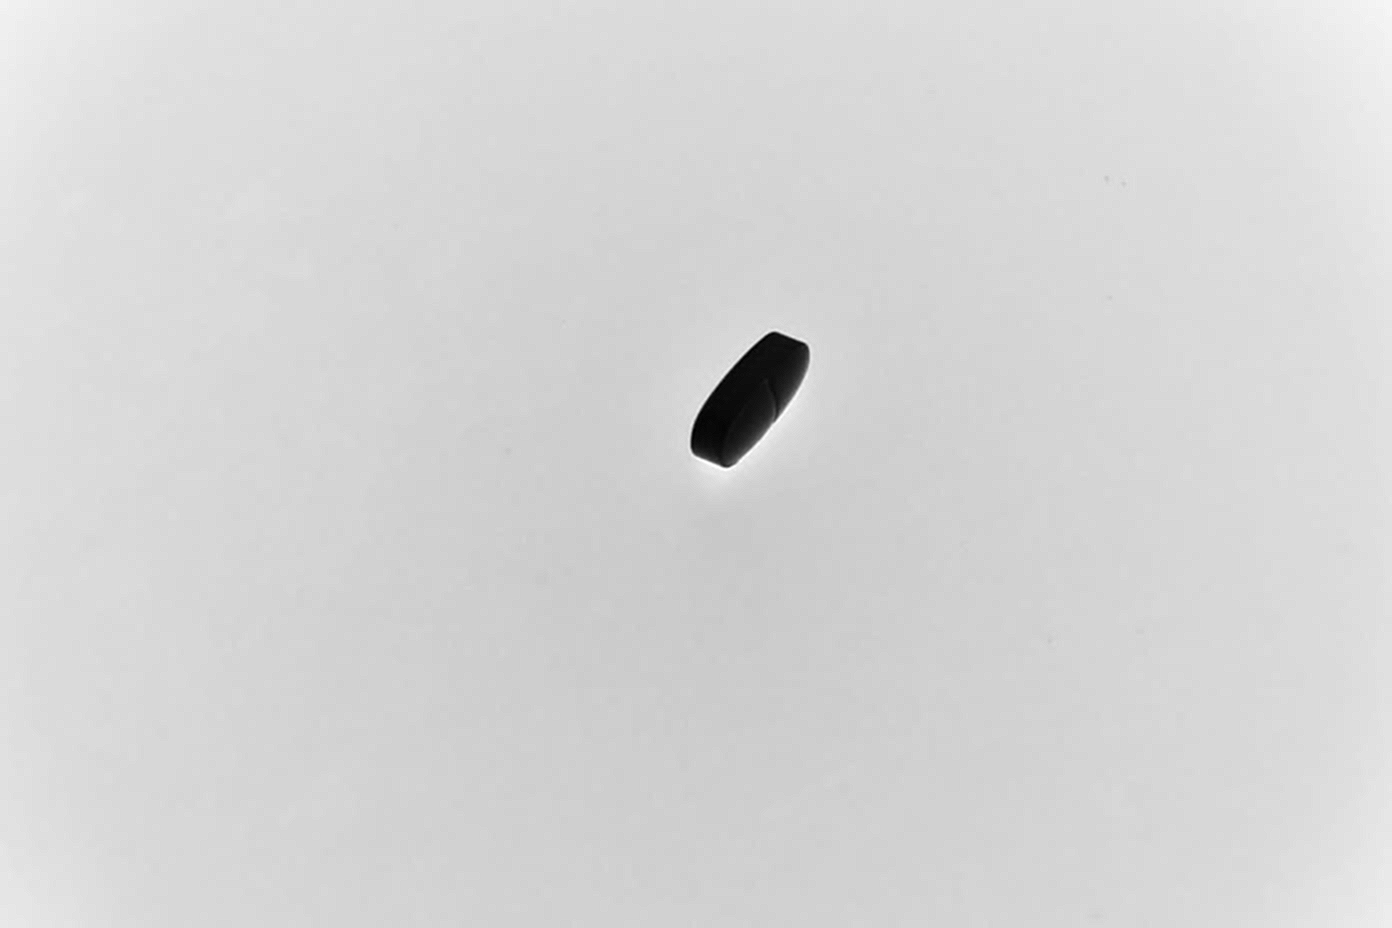

In [45]:
from google.colab.patches import cv2_imshow

img1 = segmented_images[10]
img3 = images[10]
img2 = org[10]
# Display your image
cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(img3)
# Wait for a key press
cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()

In [46]:
'''import pickle
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load the pickled list of segmented images
filename = '/content/drive/MyDrive/segmented_images.pkl'
with open(filename, 'rb') as file:
    segmented_images = pickle.load(file)

# Resize the images to the appropriate input size (224x224) for ResNet50 and convert to RGB
resized_rgb_images = []
for img in segmented_images:
    resized_img = cv2.resize(img, (224, 224))
    if len(resized_img.shape) == 2:  # Grayscale image, convert to RGB
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
    resized_rgb_images.append(resized_img)

# Convert the list of resized images to a NumPy array
resized_rgb_images = np.array(resized_rgb_images)

# Preprocess the images for ResNet50
preprocessed_images = preprocess_input(resized_rgb_images)

# Load ResNet50 without the classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the intermediate layer's activations (features)
intermediate_layer_name = 'conv5_block3_out'  # Choose an intermediate layer name from ResNet50 architecture
feature_extraction_model = Model(inputs=base_model.input, outputs=base_model.get_layer(intermediate_layer_name).output)

# Extract features from the images using the feature extraction model
features = feature_extraction_model.predict(preprocessed_images)

# Save the features to a DataFrame, with each row representing a separate image's features
features_df = pd.DataFrame(features.reshape(features.shape[0], -1))

# Display the DataFrame as a table
print(features_df)
'''
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
import pandas as pd
from PIL import Image

# Define the filename for the pickle file
filename = '/content/drive/MyDrive/segmented_images.pkl'

# Load the pickled list of segmented images
with open(filename, 'rb') as file:
    segmented_images = pickle.load(file)

# Define the transform to apply to each image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert image to RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the last fully connected layer
model.eval()

# Create an empty list to store the extracted features
features = []

# Loop through each segmented image
for segmented_img in segmented_images:
    # Convert the segmented image to PIL Image
    img = Image.fromarray(segmented_img)

    # Apply the transform to the image
    img = transform(img)

    # Move the image to the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img = img.to(device)

    # Extract features from the image using the pre-trained model
    with torch.no_grad():
        features.append(model(img.unsqueeze(0)).squeeze().cpu().numpy())

# Convert the list of extracted features to a pandas DataFrame
features_df = pd.DataFrame(features)

# Print the DataFrame
print(features_df)
'''======================================================================================================='''
# If you want to display the DataFrame with the weights column, you can concatenate the DataFrames like this:
merged_df = pd.concat([features_df, df['Weight']], axis=1)
# Use the drop method to remove the row
merged_df = merged_df.drop(44)
print(merged_df)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


        0         1         2         3         4         5         6     \
0   0.672046  0.303708  0.056931  0.364897  0.261658  0.281031  0.216723   
1   0.586179  0.293391  0.313102  0.252553  0.264107  0.154309  0.251515   
2   0.203774  0.321128  0.009448  0.245554  0.294497  0.241310  0.252197   
3   0.575792  0.620330  0.024539  0.124652  0.174120  0.813392  0.252264   
4   0.239206  0.675596  0.009298  0.293029  0.234406  1.172196  0.263070   
5   0.199104  0.597080  0.070536  0.299139  0.208550  0.518677  0.213187   
6   0.197702  0.163493  0.009385  0.344603  0.176447  0.436660  0.990725   
7   0.450585  0.714182  0.188200  0.307650  0.669321  0.677302  0.313406   
8   0.008599  0.463540  0.009926  0.270548  0.149324  1.144218  0.273179   
9   0.353491  0.943045  0.078180  0.367949  0.653004  0.837545  0.427270   
10  0.195200  0.864214  0.032156  0.104386  0.195648  0.762620  0.296075   
11  0.110286  0.546925  0.009585  0.230123  0.180326  0.557117  0.688570   
12  0.115095

In [47]:
import pandas as pd
from sklearn.decomposition import PCA

# Load your merged DataFrame (assuming you have it as 'merged_df')
# 'merged_df' should contain features in multiple columns and an output label column
# Replace 'merged_df' with the actual name of your DataFrame

# Separate the features from the output label
X = merged_df.drop(columns=['Weight'])  # Replace 'output_column_name' with the actual name of your output column
y = merged_df['Weight']

# Specify the desired number of principal components (new_dimension)
new_dimension = 43  # Adjust as needed

# Initialize PCA with the desired number of components
pca = PCA(n_components=new_dimension)

# Fit PCA to the features (X)
pca.fit(X)

# Transform the features to the reduced dimension
reduced_features = pca.transform(X)

# Create a DataFrame with the reduced features and the output label
reduced_features_df = pd.DataFrame(reduced_features, columns=[f'PC{i+1}' for i in range(new_dimension)])
reduced_features_df['Weight'] = y  # Add the output label column back

# Display the DataFrame with reduced features
print(reduced_features_df)

         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.523352  4.578807  3.319273  0.739436  0.158585  1.848430  0.193645   
1  -0.150772  4.133021  3.863920  0.096372  0.755084  0.350974 -1.457853   
2  -3.453505  0.286527  1.929613 -1.010444 -0.507325 -0.263481  0.992183   
3  -5.521791 -1.046421 -0.772424 -0.678456  1.873305  2.840337 -0.788199   
4  -3.816077  0.375820 -2.028512  0.914537  0.581161 -0.240937 -0.581289   
5  -4.028992  0.650611  0.389337 -0.869294 -1.096371 -0.504298 -0.810617   
6   3.466438 -4.920283  0.256702 -0.378123  2.467845 -0.707456  0.468611   
7   2.426616  5.770077 -2.683025 -1.310353  2.296979  0.239991 -0.114709   
8  -2.932102 -3.720809 -2.862228  1.495505  0.454419 -1.097322 -0.152478   
9   4.070535  5.975913 -3.986994 -0.028561  1.218284  0.608710  2.139635   
10 -5.476165 -1.402966 -0.742227 -0.468757 -0.682765  2.482416 -0.809220   
11 -3.382360 -4.053447 -0.933413  0.728901  0.456764  0.823468  2.168138   
12  6.424785

In [48]:
print("Shape of reduced_features_df:", reduced_features_df.shape)
print("Shape of df:", df.shape)
print("Duplicate rows in reduced_features_df:", reduced_features_df.duplicated().sum())
print("Duplicate rows in df:", df.duplicated().sum())
print("Missing values in reduced_features_df:", reduced_features_df.isna().sum().sum())
print("Missing values in df:", df.isna().sum().sum())
print("First few rows of reduced_features_df:\n", reduced_features_df.head())
print("First few rows of df:\n", df.head())

Shape of reduced_features_df: (44, 44)
Shape of df: (45, 1)
Duplicate rows in reduced_features_df: 0
Duplicate rows in df: 37
Missing values in reduced_features_df: 0
Missing values in df: 0
First few rows of reduced_features_df:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.523352  4.578807  3.319273  0.739436  0.158585  1.848430  0.193645   
1 -0.150772  4.133021  3.863920  0.096372  0.755084  0.350974 -1.457853   
2 -3.453505  0.286527  1.929613 -1.010444 -0.507325 -0.263481  0.992183   
3 -5.521791 -1.046421 -0.772424 -0.678456  1.873305  2.840337 -0.788199   
4 -3.816077  0.375820 -2.028512  0.914537  0.581161 -0.240937 -0.581289   

        PC8       PC9      PC10  ...      PC35      PC36      PC37      PC38  \
0 -0.333051  1.967403 -0.469077  ...  0.526765  0.145272  0.150447  0.091355   
1  1.329598  0.585294 -0.194557  ... -0.203899 -0.065080 -0.203311 -0.157095   
2 -1.519234 -0.254885 -1.370388  ...  0.127799 -0.185683 -0.113732  0.072103  

In [49]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming your features and labels are stored in the following DataFrames/arrays
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Assuming you have features in reduced_features_df and labels in a DataFrame named df
# Extract features and labels
X = reduced_features_df.values  # Features (PC1 to PC43)
y = reduced_features_df['Weight'].values  # Target values (Pill Weight)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can further scale or normalize your features here if needed
# Example: Standardization (z-score normalization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

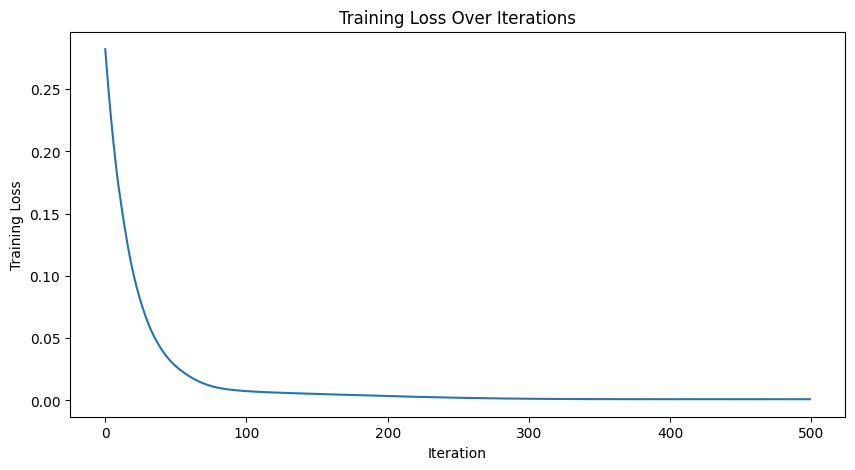

   True_Values  Predicted_Values True_Class
0        1.800          2.137064   rejected
1        1.797          1.321052   rejected
2        1.797          2.094548   rejected
3        1.798          1.736402   rejected
4        1.797          1.714307   rejected
5        1.800          1.422665   rejected
6        1.738          2.424271   rejected
7        1.789          1.396456   rejected
8        1.772          3.119544   selected


In [64]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt  # Import the pyplot module from matplotlib

# Initialize the FNN model with the desired parameters
# model = MLPRegressor(
#     hidden_layer_sizes=(10,),
#     activation='relu',
#     solver='adam',
#     alpha=0.001,
#     random_state=42,
#     max_iter=1000,
#     learning_rate_init=0.0001
# )
model = MLPRegressor(
    hidden_layer_sizes=(10, 10, 10),  # Increase network depth and width
    activation='relu',  # ReLU is a common activation function
    solver='adam',  # 'adam' optimizer often works well
    alpha=0.002,  # Regularization strength, adjust as needed
    max_iter=300,  # Increase maximum iterations
    random_state=42
)
# Initialize an empty list to store training loss
training_loss = []

# Training loop
for i in range(500):  # Adjust the number of iterations as needed
    # Fit the model for one more iteration
    model.partial_fit(X_train, y_train)

    # Calculate the current training loss and append it to the list
    current_loss = model.loss_
    training_loss.append(current_loss)

# Plot the training loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(training_loss)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Iterations')
plt.show()

# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({'True_Values': y_test, 'Predicted_Values': y_pred})

# Convert 'True_Values' to float
results_df['True_Values'] = results_df['True_Values'].astype(float)

# Add a new column for classification based on the specified range
results_df['True_Class'] = results_df['True_Values'].apply(lambda x: 'selected' if 1.75 <= x <= 1.78 else 'rejected')

# Display the DataFrame with true values, predicted values, and classification
print(results_df)

Mean Absolute Error (MAE): 0.45094951133884187
Accuracy: 0.8888888888888888
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


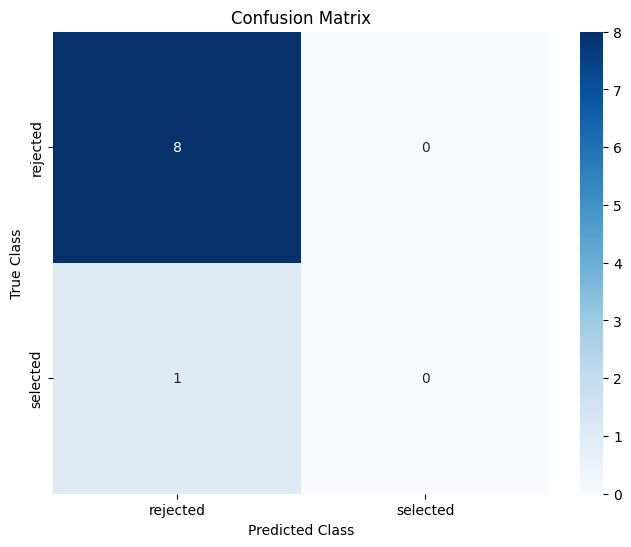

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Assuming you already have the 'results_df' DataFrame

# Add a new column for classification based on the specified range for predicted values
results_df['Predicted_Class'] = results_df['Predicted_Values'].apply(lambda x: 'selected' if 1.75 <= x <= 1.78 else 'rejected')

# Calculate Mean Absolute Error (MAE) to evaluate the model
mae = mean_absolute_error(results_df['True_Values'], results_df['Predicted_Values'])
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate and print classification metrics
accuracy = accuracy_score(results_df['True_Class'], results_df['Predicted_Class'])
precision = precision_score(results_df['True_Class'], results_df['Predicted_Class'], pos_label='selected')
recall = recall_score(results_df['True_Class'], results_df['Predicted_Class'], pos_label='selected')
f1 = f1_score(results_df['True_Class'], results_df['Predicted_Class'], pos_label='selected')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot the confusion matrix
conf_mat = confusion_matrix(results_df['True_Class'], results_df['Predicted_Class'])

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['rejected', 'selected'], yticklabels=['rejected', 'selected'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [66]:
results_df

,True_Values,Predicted_Values,True_Class,Predicted_Class
0,1.800,2.137064,rejected,rejected
1,1.797,1.321052,rejected,rejected
2,1.797,2.094548,rejected,rejected
3,1.798,1.736402,rejected,rejected
4,1.797,1.714307,rejected,rejected
5,1.800,1.422665,rejected,rejected
6,1.738,2.424271,rejected,rejected
7,1.789,1.396456,rejected,rejected
8,1.772,3.119544,selected,rejected


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['True_Values'].plot(kind='hist', bins=20, title='True_Values')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Predicted_Values'].plot(kind='hist', bins=20, title='Predicted_Values')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('True_Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='True_Values', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='True_Values', y='Predicted_Values', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['True_Values']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('True_Class')):
  _plot_series(series, series_name, i)
  fig.legend(title='True_Class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('True_Values')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Predicted_Values']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('True_Class')):
  _plot_series(series, series_name, i)
  fig.legend(title='True_Class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Predicted_Values')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('True_Class')):
  _plot_series(series, series_name, i)
  fig.legend(title='True_Class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['True_Values'].plot(kind='line', figsize=(8, 4), title='True_Values')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Predicted_Values'].plot(kind='line', figsize=(8, 4), title='Predicted_Values')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['True_Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='True_Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['True_Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='True_Values', y='True_Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['True_Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Predicted_Values', y='True_Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
'''accuracy_list = []
psnr_list = []
mse_list = []
asnr_list = []

for i in range(len(org)):
    accuracy = cv2.norm(org[i], images[i], cv2.NORM_L2) / (org[i].shape[0] * org[i].shape[1])
    accuracy_list.append(accuracy)
    # Calculate PSNR
    psnr = cv2.PSNR(org[i], images[i])
    psnr_list.append(psnr)

    # Calculate MSE
    mse = np.square(np.subtract(org[i], images[i])).mean()
    mse_list.append(mse)

    # Calculate ASNR
    asnr = 10 * np.log10(np.mean(np.square(images[i])) / mse)
    asnr_list.append(asnr)

# Calculate PSNR, MSE, and ASNR
average_psnr = sum(psnr_list) / len(psnr_list)
average_mse = sum(mse_list) / len(mse_list)
average_asnr = sum(asnr_list) / len(asnr_list)

print("Average PSNR:", average_psnr)
print("Average MSE:", average_mse)
print("Average ASNR:", average_asnr)'''